In [114]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate, SdgGate
from random import choice, choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigoV2
from qiskit.providers.aer import Aer
from typing import List, Tuple, Dict
from qiskit.providers.backend import Backend, BackendV1, BackendV2
from sympy import singularities

plt.rcParams["figure.figsize"] = (6.4,4.0)

In [115]:
from FullProcedure import Layer, LearningProcedure, ProcedureAnalysis

QUBIT = int
DOUBLE_GATE = 2
SINGLE_GATE = 1
NUM_BASES = 9
layer = Layer([0,1],[('cx',(0,1))],[])
backend = FakeVigoV2()
sim = Aer.get_backend("qasm_simulator")

tglp = LearningProcedure(layer, backend)

In [116]:
from qiskit.providers.aer.noise import pauli_error
from random import random

errorgen = 4
p_single = .001
errorops = choices(pauli_basis(2, pauli_list = True), k=errorgen)
errorprobs = [random()*.05/errorgen for op in errorops]
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])
singlequbit_error = pauli_error([(Pauli("X"), p_single), (Pauli("Y"), p_single), (Pauli("Z"), p_single),(Pauli("I"), 1-3*p_single)])
noise_model.add_all_qubit_quantum_error(singlequbit_error, ['x','sx','rz'])

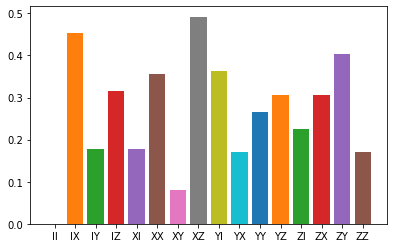

In [117]:

real_errors = {}
q2_transfer = PTM(twoqubit_error.to_quantumchannel())
q1_transfer = PTM(singlequbit_error.to_quantumchannel())
transfer_matrix = q1_transfer.tensor(q1_transfer).compose(q2_transfer).data
#transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real)

In [118]:
circuits, metadatas = tglp.procedure([0,2,4,8,16,32], [100,32,32,32,32,32],100)

In [119]:
tglp.depths = [0,2,4,8,16,32]
tglp.single_samples = 100

In [120]:
analysis = ProcedureAnalysis.fromExperiment(tglp)

In [121]:
results = sim.run(circuits, shots=250, noise_model = noise_model).result().get_counts()

In [122]:
basis_dict = analysis.analyze(results, metadatas)

In [123]:
def display(*paulis):
    fidelities = []
    fidelities_calculated = []
    ax = np.arange(len(tglp.model_paulis))
    for p in tglp.model_paulis:
        fid = basis_dict[p]['fidelity']
        if(basis_dict[p]['type'] == 'pair'):
            pair = tglp.commute_layer(p)
            fid = fid**2/basis_dict[pair]['fidelity']
        fidelities.append(fid)
        fidelities_calculated.append(real_errors[p])
    plt.bar(ax+.2, [10*(1-f) for f in fidelities], .4,color='b')
    plt.bar(ax-.2, [10*(1-f) for f in fidelities_calculated],.4, color='r')
    plt.xticks(ax, tglp.model_paulis)

/home/ben/.local/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


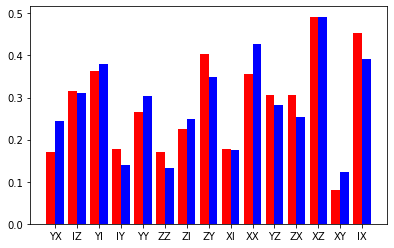

In [124]:
display(*tglp.model_paulis)

In [125]:
F1 = []
F2 = []
fidelities = []
for key in tglp.model_paulis:
    F1.append(key)
    fidelities.append(basis_dict[key]['fidelity'])
    if basis_dict[key]["type"] == "pair":
        pair = tglp.commute_layer(key)
        F2.append(pair)
    else:
        F2.append(Pauli("I"*tglp.n))

In [126]:
import scipy as sc
def fit_model():
    F1 = []
    F2 = []
    fidelities = []
    for key in tglp.model_paulis:
        F1.append(key)
        fidelities.append(basis_dict[key]['fidelity'])
        if basis_dict[key]["type"] == "pair":
            pair = tglp.commute_layer(key)
            F2.append(pair)
        else:
            F2.append(Pauli("I"*tglp.n))
    
    sprod = lambda a,b: int(a.anticommutes(b))
    M1 = [[sprod(a,b) for a in tglp.model_paulis] for b in F1]
    M2 = [[sprod(a,b) for a in tglp.model_paulis] for b in F2]
    coeffs,rnorm = sc.optimize.nnls(np.add(M1,M2), -np.log(fidelities))
    print(rnorm)
    return list(zip(coeffs, tglp.model_paulis))

In [129]:
analysis.graph(Pauli("XZ"))

NameError: name 'expfit' is not defined

0.03295438953507978


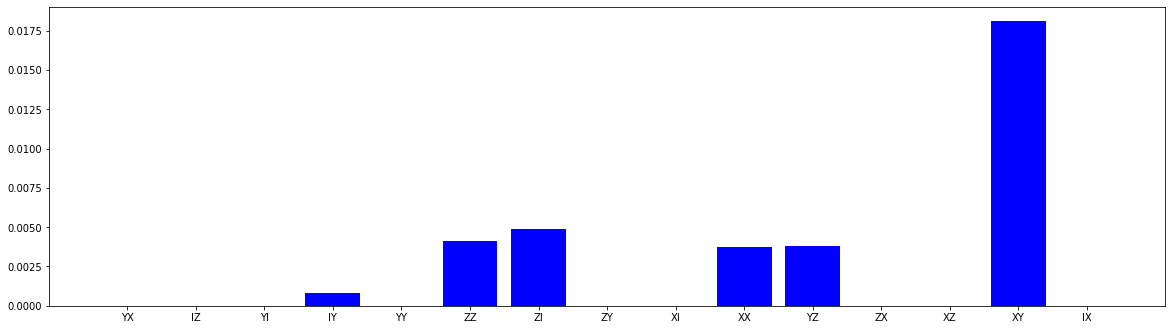

In [130]:
plt.rcParams["figure.figsize"] = (20,5.5)
for coeff,term in fit_model():
        plt.bar(term.to_label(), coeff, color='b')